<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/main/autocodifocador_waveform_1demayo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount your Google drive so that you only have to download the data only once
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
######load your data#######
import os
from os import walk
import numpy as np
# load your data
paths = ["/content/drive/MyDrive/sintesis_dataset_/am","/content/drive/MyDrive/sintesis_dataset_/fm",
         "/content/drive/MyDrive/sintesis_dataset_/grain","/content/drive/MyDrive/sintesis_dataset_/res",
         "/content/drive/MyDrive/sintesis_dataset_/waveshapping"]
#print(paths)
audios = []
labels = []
labelsname = []
for i in paths:
    for (dirpath, dirnames, filenames) in walk(i):
        for filename in filenames:
            audios.append(os.path.join(dirpath, filename))
            #audios.append(filename)
            #print(audios)
            if filename.startswith("am"):
                labels.append(0)
                labelsname.append("am")
            elif filename.startswith("fm"):
                labels.append(1)
                labelsname.append("fm")
            elif filename.startswith("grain"):
                labels.append(2)
                labelsname.append("grain")
            elif filename.startswith("res"):
                labels.append(3)
                labelsname.append("res")
            elif filename.startswith("waveshapping"):
                labels.append(4)
                labelsname.append("waveshapping")
        #print(filenames)
        #audios.append(filenames)
        break


In [ ]:
print(len(audios))
audio = [audios[i] for i in range(1000,3000,2)]
print(len(audio))

5001
1000


In [ ]:
###rawwaveform
import librosa
import numpy as np

waveforms = []
#nsr = 22050
for track in audio:
  if track.endswith("wav"):
    y,fs = librosa.load(track)
    #y = librosa.resample(y,fs,nsr)
    waveforms.append(y[:48000])#[...,np.newaxis][...,np.newaxis][...,np.newaxis])

#data = np.array(data)
#datastft = np.array(datastft)
waveforms = np.array(waveforms)

#print(data.shape)
#print(datastft.shape)
print(waveforms.shape)

(1000, 48000)


In [ ]:
# visualize a few raw datapoints to get an idea about your "raw" data
# what are the units in the plot you are showing us?
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
sonidos = [0,50,100,150,200]
#sonidos = [i for i in range(5)]
labelsname = ["Am","Fm","Grain","Res","Waveshapping"]

for i, x in enumerate(sonidos):
    plt.subplot(2, 5, i+ 1).set_title(labelsname[i])
    librosa.display.waveplot(waveforms[x])
plt.tight_layout()

plt.show()

In [ ]:
###normalizar y cambio de dimensionalidad
mu_wave = np.mean(waveforms, axis= 1)[...,np.newaxis]#[...,np.newaxis][...,np.newaxis]
max_wave = np.max(waveforms, axis=1)[...,np.newaxis]#[...,np.newaxis][...,np.newaxis]

#X = (data-mu_)/s_
Xw = (waveforms-mu_wave)/max_wave
Xw = Xw
print(Xw.shape)

(1000, 48000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
# visualize a few raw datapoints to get an idea about your "raw" data
# what are the units in the plot you are showing us?
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
sonidos = [0,50,100,150,200]
#sonidos = [i for i in range(5)]
labelsname = ["Am","Am","Fm","Fm","Grain","Grain","Res","Res","Waveshapping","Waveshapping"]

for i, x in enumerate(sonidos):
    plt.subplot(2, 5, i+ 1).set_title(labelsname[i])
    librosa.display.waveplot(Xw[x])
plt.tight_layout()

plt.show()

In [ ]:
Ntracks = 250
track_idx = np.random.choice(Ntracks,Ntracks,replace=False)

### 85% de entrenamiento
### 100% de validación
### 50% de testeo

tr_tracks = [waveforms[i] for i in track_idx[:225]]
vl_tracks = [waveforms[i] for i in track_idx[225:]]

tr_tracks = np.array(tr_tracks)
vl_tracks = np.array(vl_tracks)
#print(len(tr_tracks))
print(tr_tracks.shape)
print(vl_tracks.shape)
#ts_tracks = [all_tracks[i] for i in track_idx[-50:]]

In [ ]:
Ntracks = 250
track_idx = np.random.choice(Ntracks,Ntracks,replace=False)
tr_tracks = [waveforms[i] for i in track_idx[0:]]
tr_tracks = np.array(tr_tracks)
print(tr_tracks.shape)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

input = layers.Input((48000,1))

# Encoder
#x = layers.Conv1D(64, 4, activation="relu", padding="same",strides=4)(input)

x = layers.Conv1D(4, 64, activation="relu", padding="same",strides=4)(input)
x = layers.Conv1D(4,128, activation="relu", padding="same",strides=4)(x)
x = layers.Conv1D(4,256, activation="relu", padding="same",strides=4)(x)
latent = layers.Conv1D(4,512, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv1DTranspose(4,512, activation="relu",padding= "same")(latent)
x = layers.Conv1DTranspose(4,256, activation="relu",padding= "same")(x)
x = layers.Conv1DTranspose(4,128, activation="relu",padding= "same",strides= 4)(x)
x = layers.Conv1DTranspose(4,64, activation="relu",padding= "same",strides=4)(x)
x = layers.Conv1DTranspose(1,1, activation="tanh", padding="same",strides=4)(x) #aguas con Relu si tus espectrogramas tienen valores negativos
#x = layers.Conv1D(1,1, activation="tanh", padding="same")(x)
# Autoencoder
#autoencoder = Model(inputs=input, outputs=(x,latent))
autoencoder = Model(input, x)

autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

input = layers.Input((48000,1))

# Encoder
#x = layers.Conv1D(64, 4, activation="relu", padding="same",strides=4)(input)

x = layers.Conv1D(64, 4, padding="same",strides=4)(input)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(128,4, padding="same",strides=4)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(256,4, padding="same",strides=2)(x)
x = layers.LeakyReLU()(x)
latent = layers.Conv1D(512,4, padding="same",strides=3)(x)
latent = layers.LeakyReLU()(latent)


# Decoder
x = layers.Conv1DTranspose(512,4,padding= "same")(latent)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(256,4,padding= "same",strides= 3)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(128,4,padding= "same",strides= 2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(64,4,padding= "same",strides=4)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv1DTranspose(1,1, activation="tanh", padding="same",strides=4)(x) #aguas con Relu si tus espectrogramas tienen valores negativos
#x = layers.Conv1D(1,1, activation="tanh", padding="same")(x)
# Autoencoder
#autoencoder = Model(inputs=input, outputs=(x,latent))
autoencoder = Model(input, x)

autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

In [ ]:
###nuevo bueno
from tensorflow.keras import layers
from tensorflow.keras.models import Model

input = layers.Input((48000,1))

# Encoder
#x = layers.Conv1D(64, 4, activation="relu", padding="same",strides=4)(input)

x = layers.Conv1D(64, 4, padding="same",strides=2)(input)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(128,4, padding="same",strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1D(64,4, padding="same")(x)
x = layers.LeakyReLU()(x)
#x = layers.Conv1D(256,4, padding="same",strides=2)(x)
#x = layers.LeakyReLU()(x)
#latent = layers.Conv1D(512,4, padding="same",strides=2)(x)
#latent = layers.LeakyReLU()(latent)
latent = layers.Conv1D(1,4, padding="same")(x)

# Decoder
x = layers.Conv1DTranspose(64,4,padding= "same")(latent)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(128,4,padding= "same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv1DTranspose(64,4,padding= "same",strides= 2)(x)
x = layers.LeakyReLU()(x)
#x = layers.Conv1DTranspose(1,4,padding= "same",strides=1)(x)
#x = layers.LeakyReLU()(x)

x = layers.Conv1DTranspose(1, 1, activation="tanh", padding="same",strides=2)(x) 
#x = layers.Conv1D(1,1, activation="tanh", padding="same")(x)
# Autoencoder
#autoencoder = Model(inputs=input, outputs=(x,latent))
autoencoder = Model(input, x)

autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48000, 1)]        0         
                                                                 
 conv1d_28 (Conv1D)          (None, 24000, 64)         320       
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 24000, 64)         0         
                                                                 
 conv1d_29 (Conv1D)          (None, 12000, 128)        32896     
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 12000, 128)        0         
                                                                 
 conv1d_30 (Conv1D)          (None, 12000, 64)         32832     
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 12000, 64)         0   

In [ ]:
tr_logs = autoencoder.fit(
    x= waveforms,
    y= waveforms,
    epochs= 50,
    batch_size= 2,
    shuffle=True,
   #validation_data=(vl_tracks,vl_tracks),
)

Epoch 1/50
500/500 [==============================] - 12s 22ms/step - loss: 0.0367
Epoch 2/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0341
Epoch 3/50
500/500 [==============================] - 11s 23ms/step - loss: 0.0318
Epoch 4/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0312
Epoch 5/50
500/500 [==============================] - 11s 21ms/step - loss: 0.0310
Epoch 6/50
500/500 [==============================] - 11s 21ms/step - loss: 0.0307
Epoch 7/50
500/500 [==============================] - 11s 21ms/step - loss: 0.0305
Epoch 8/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0305
Epoch 9/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0309
Epoch 10/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0304
Epoch 11/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0306
Epoch 12/50
500/500 [==============================] - 11s 22ms/step - loss: 0.0304
E

In [ ]:
autoencoder.save('/content/drive/MyDrive/sintesis_dataset/autoencoder')

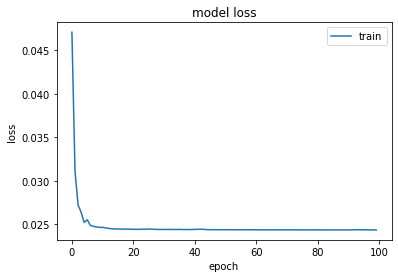

In [ ]:
###CNN
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(tr_logs.history['loss'])
#plt.plot(tr_logs.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/sintesis_dataset/autoencoder')
#model.summary()
layer_name = 'conv1d_3'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(waveforms[:700])

In [ ]:
print(intermediate_output.shape)
print(intermediate_output[0].shape)
latent = []
for i in range(len(waveforms[:700])):
  latent.append(intermediate_output[0].numpy().flatten())
latent = np.array(latent)

print(latent.shape)

In [ ]:
# plot ALL of your training data using t-SNE and PCA (must plot both)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE 
###t-SNE
## for t-SNE
fig = plt.figure(1, figsize=(12, 6))
ax = Axes3D(fig,elev=-20, azim=100)
tsne = TSNE(n_components= 3)  # create an instance of t-SNE
ax = plt.axes(projection = "3d")
X_tsne = tsne.fit_transform(latent)  # fit and transform the data
ax.scatter3D(X_tsne[:199, 0], X_tsne[:199, 1], X_tsne[:199, 2], c='red', label='am')
ax.scatter3D(X_tsne[200:399, 0], X_tsne[200:399, 1], X_tsne[200:399, 2], c='green', label='fm')
ax.scatter3D(X_tsne[400:599, 0], X_tsne[400:599, 1], X_tsne[400:599, 2], c='blue', label='grain')
ax.scatter3D(X_tsne[600:799, 0], X_tsne[600:799, 1], X_tsne[600:799, 2], c='orange', label='res')
#ax.scatter3D(X_tsne[800:999, 0], X_tsne[800:999, 1], X_tsne[800:999, 2], c='yellow', label='waveshapping')
ax.view_init(30,60)
plt.title('T-SNE 3D')
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
ax.set_zlabel('TSNE 3')
ax.legend()
plt.show()

In [ ]:
fig = plt.figure(1, figsize=(12, 6))
#a3x = Axes3D(fig,elev=-20, azim=100)
tsne = TSNE(n_components= 2)  # create an instance of t-SNE
#ax = plt.axes(projection = "3d")
X_tsne = tsne.fit_transform(latent)  # fit and transform the data
plt.scatter(X_tsne[:199, 0], X_tsne[:199, 1], c='red', label='am')
plt.scatter(X_tsne[200:399, 0], X_tsne[200:399, 1], c='green', label='fm')
plt.scatter(X_tsne[400:599, 0], X_tsne[400:599, 1], c='blue', label='grain')
plt.scatter(X_tsne[600:799, 0], X_tsne[600:799, 1], c='orange', label='res')
plt.scatter(X_tsne[800:999, 0], X_tsne[800:999, 1], c='yellow', label='waveshapping')
#ax.view_init(30,60)
plt.title('T-SNE 3D')
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
#ax.set_zlabel('TSNE 3')
ax.legend()
plt.show()

(10, 48000, 1)


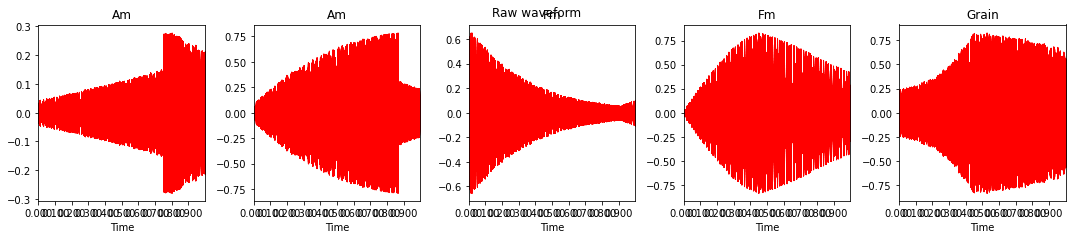

In [ ]:
a = autoencoder.predict(waveforms)
print(a.shape)
#for i in a:
#  print(i)
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
labelsname = ["Am","Am","Fm","Fm","Grain","Grain","Res","Res","Waveshapping","Waveshapping"]

for i in range(5):
    plt.subplot(2, 5, i+ 1).set_title(labelsname[i])
    librosa.display.waveplot(a[i].flatten(),sr=48000,color='r')
plt.tight_layout()

plt.show()

In [ ]:
import IPython
sr = 48000
IPython.display.Audio(data= a[2].flatten(), rate=sr)

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


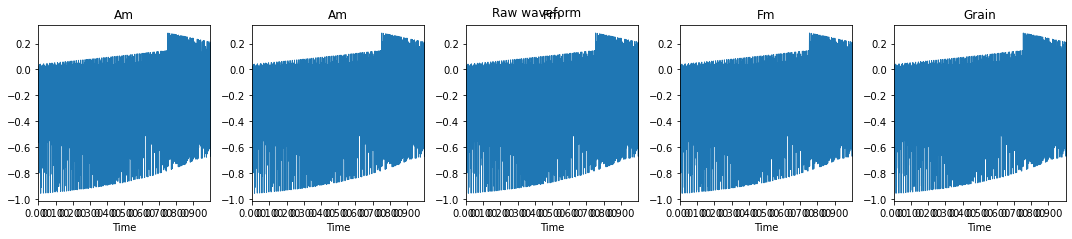

In [ ]:

plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
labelsname = ["Am","Am","Fm","Fm","Grain","Grain","Res","Res","Waveshapping","Waveshapping"]

for i in range(5):
    plt.subplot(2, 5, i+ 1).set_title(labelsname[i])
    librosa.display.waveplot(waveforms,sr)
plt.tight_layout()

plt.show()

In [ ]:
import IPython
sr = 48000
IPython.display.Audio(data= waveforms[2], rate=sr)